# Regression example using TF-MELT
This is a basic regression example using the models in TF-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib

In [1]:
from importlib_metadata import version

print(f"TF-MELT version: {version('tfmelt')}")

TF-MELT version: 0.4.4


In [2]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [3]:
from tfmelt.utils.preprocessing import get_normalizers
from sklearn.model_selection import train_test_split

# Get the normalizers using the tfmelt library
x_normalizer, y_normalizer = get_normalizers(norm_type="standard", n_normalizers=2)

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

# Hyperparameters
Set consistent hyperparameters for all models for comparisons sake.

In [4]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-3
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.1
input_dropout = 0.1
batch_norm = False
output_activation = "linear"

width = 8
depth = 2

# ResNet specific hyperparameters
layers_per_block = 4

## Artificial Neural Network (ANN)
Create and train an ANN using TF-MELT.

In [5]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
ann_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
)

# Compile the model
ann_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
ann_model.build(input_shape=(None, n_features))
ann_model.summary()


Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  27        
                                                                 
 dense_block (DenseBlock)    multiple                  160       
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              multiple                  27        
                                                     

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [6]:
# Train the model
history = ann_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.1136 - val_loss: 1.3143
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 1.0205 - val_loss: 1.2493
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 0.9334 - val_loss: 1.1834
Epoch 4/300
25/25 [==============================] - 0s 892us/step - loss: 0.9201 - val_loss: 1.1142
Epoch 5/300
25/25 [==============================] - 0s 831us/step - loss: 0.8346 - val_loss: 1.0493
Epoch 6/300
25/25 [==============================] - 0s 896us/step - loss: 0.7960 - val_loss: 0.9641
Epoch 7/300
25/25 [==============================] - 0s 862us/step - loss: 0.7746 - val_loss: 0.8831
Epoch 8/300
25/25 [==============================] - 0s 886us/step - loss: 0.7201 - val_loss: 0.7842
Epoch 9/300
25/25 [==============================] - 0s 900us/step - loss: 0.6460 - val_loss: 0.6686
Epoch 10/300
25/25 [==============================] - 0s 887us/step - loss: 0.5730 - val_loss: 0.

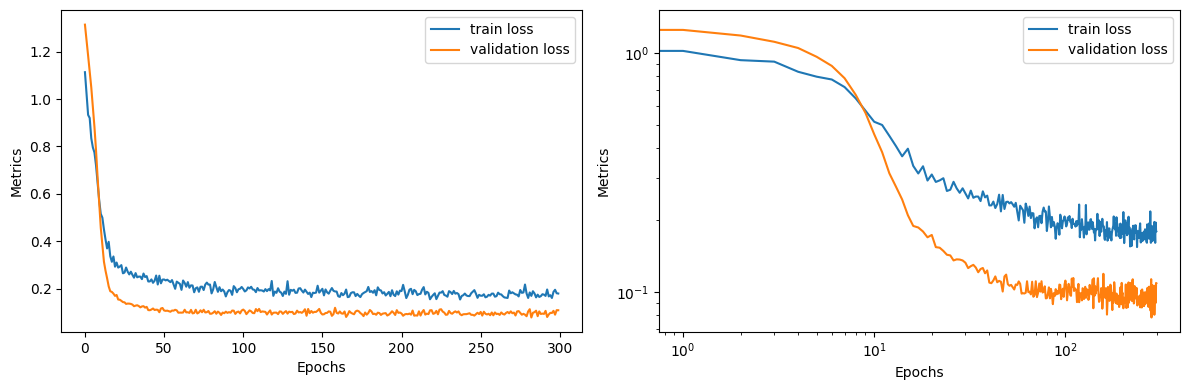

In [7]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [8]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(ann_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(ann_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(ann_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

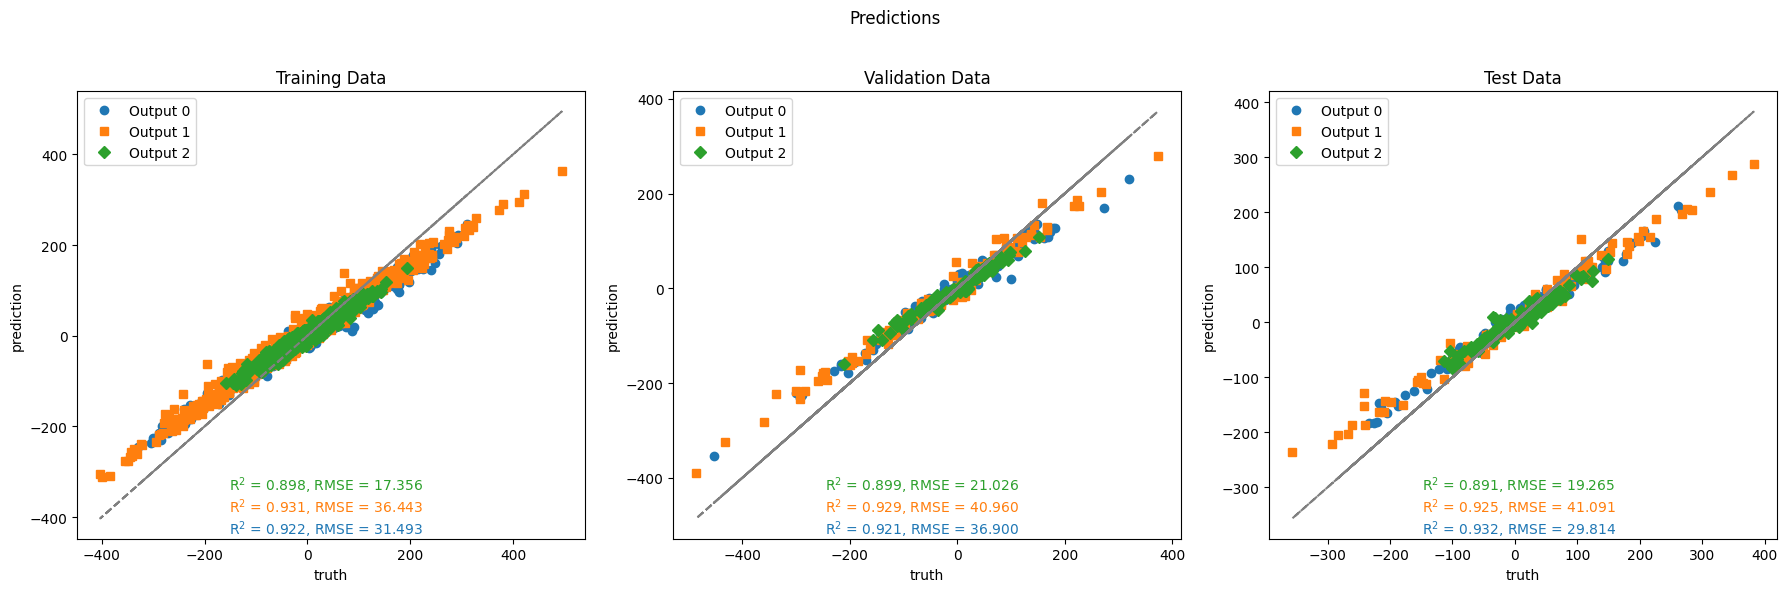

In [9]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

Let's do a test of the model serialization and loading

INFO:tensorflow:Assets written to: ann_model/assets


INFO:tensorflow:Assets written to: ann_model/assets
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


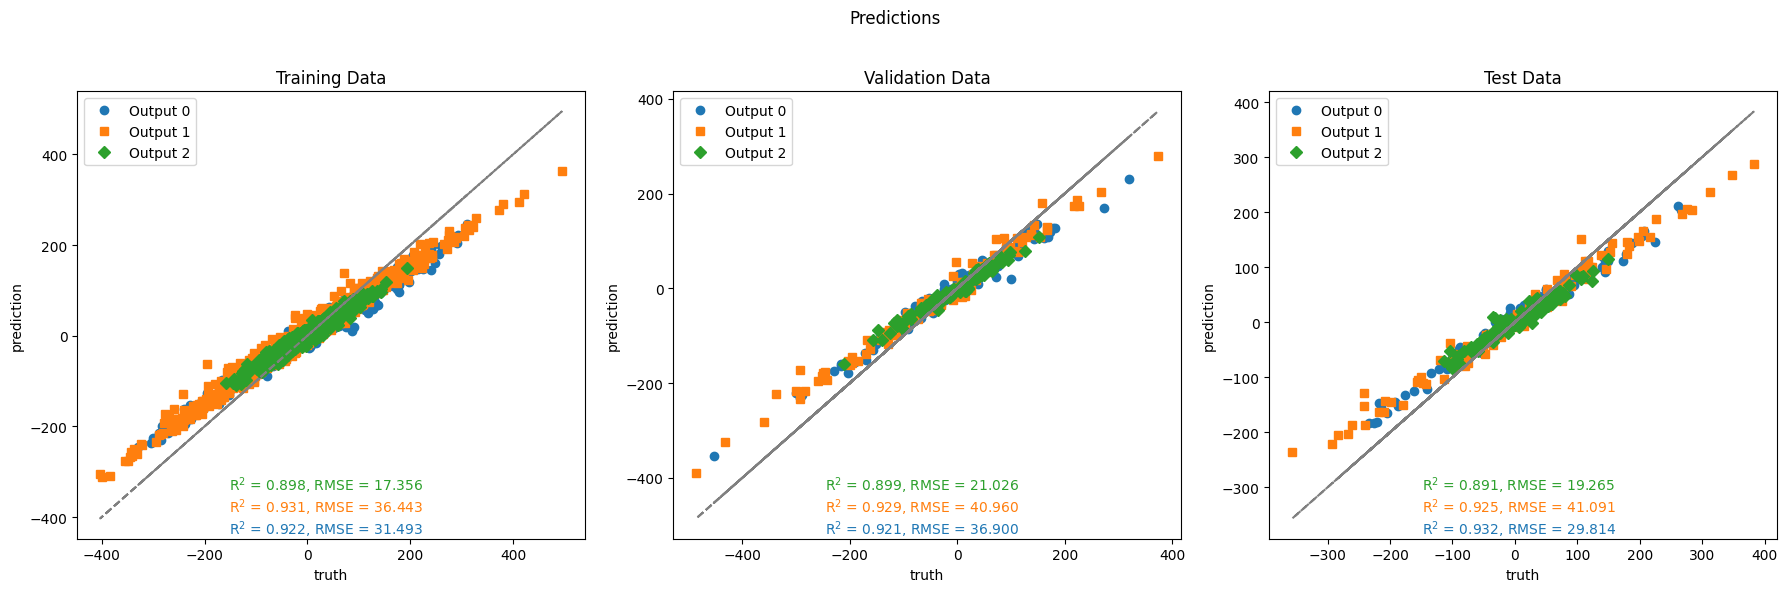

In [10]:
from tensorflow.keras.models import load_model

# Save the ann model
ann_model.save("ann_model")

# Load the ann model
ann_model_loaded = load_model("ann_model")

# Make predictions using the loaded model
pred_train_loaded = make_predictions(ann_model_loaded, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val_loaded = make_predictions(ann_model_loaded, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test_loaded = make_predictions(ann_model_loaded, x_test, y_normalizer=y_normalizer, unnormalize=True)

# Plot the predictions
plot_predictions(pred_train_loaded, y_train_real, pred_val_loaded, y_val_real, pred_test_loaded, y_test_real)


In [11]:
# recompile with a different loss function
ann_model_loaded.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss="mae",
)

# do some additional training on loaded model
history_loaded = ann_model_loaded.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)


Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 0.2819 - val_loss: 0.2646
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 0.2912 - val_loss: 0.2485
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 0.2861 - val_loss: 0.2610
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 0.2837 - val_loss: 0.2553
Epoch 5/300
25/25 [==============================] - 0s 861us/step - loss: 0.2770 - val_loss: 0.2720
Epoch 6/300
25/25 [==============================] - 0s 849us/step - loss: 0.2841 - val_loss: 0.2610
Epoch 7/300
25/25 [==============================] - 0s 881us/step - loss: 0.2799 - val_loss: 0.2560
Epoch 8/300
25/25 [==============================] - 0s 884us/step - loss: 0.2853 - val_loss: 0.2574
Epoch 9/300
25/25 [==============================] - 0s 915us/step - loss: 0.2755 - val_loss: 0.2597
Epoch 10/300
25/25 [==============================] - 0s 882us/step - loss: 0.2868 - val_loss: 0.25

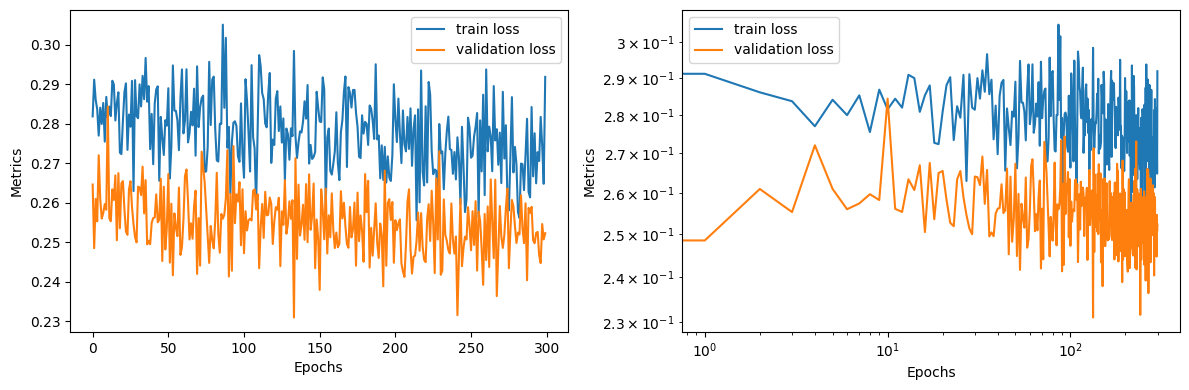

In [12]:
# Plot the loss function over time
plot_history(history_loaded, metrics=["loss"], plot_log=True)


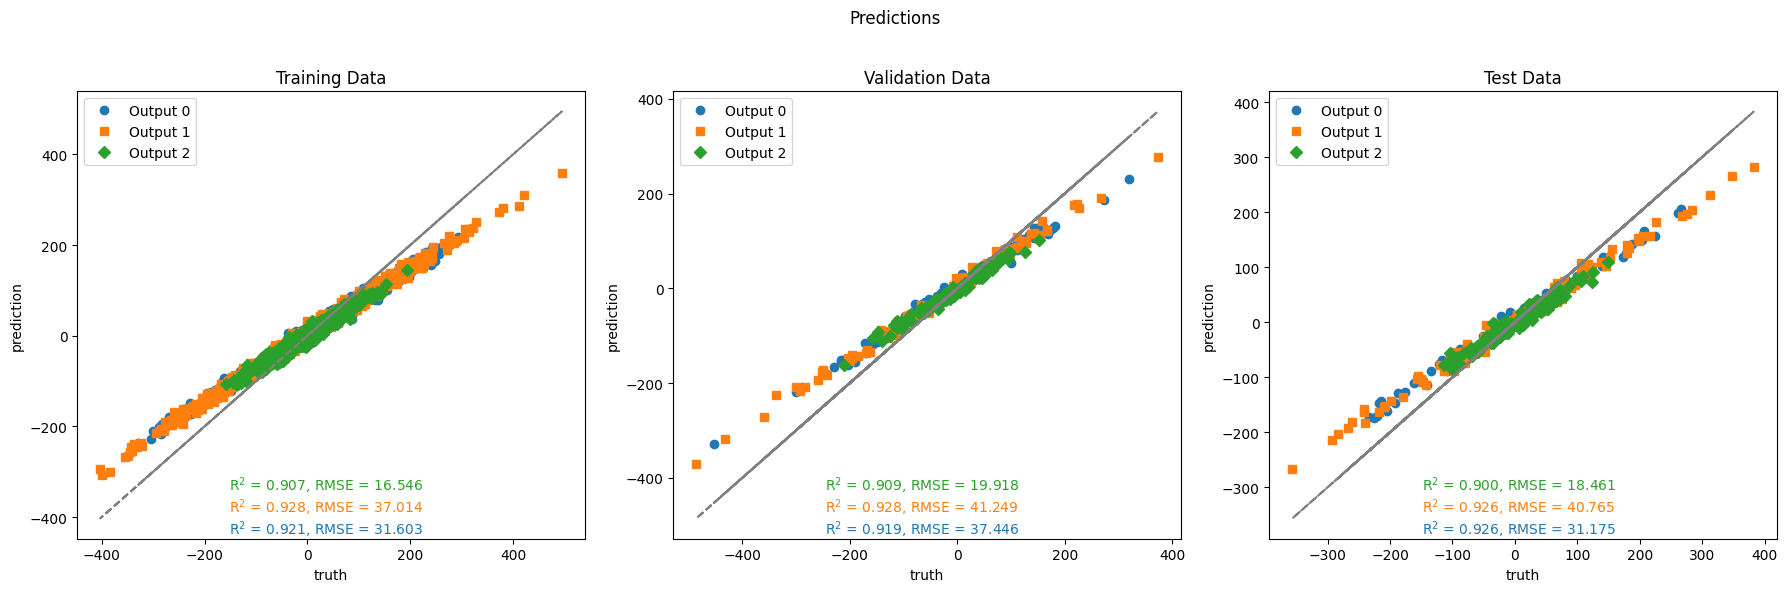

In [13]:
# make predictions
pred_train_loaded = make_predictions(ann_model_loaded, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val_loaded = make_predictions(ann_model_loaded, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test_loaded = make_predictions(ann_model_loaded, x_test, y_normalizer=y_normalizer, unnormalize=True)

# Plot the predictions
plot_predictions(pred_train_loaded, y_train_real, pred_val_loaded, y_val_real, pred_test_loaded, y_test_real)


Let's do a quick test to see if we can compute the gradients of the model...

Shape of tfmelt jacobian: (1, 3, 1, 10)


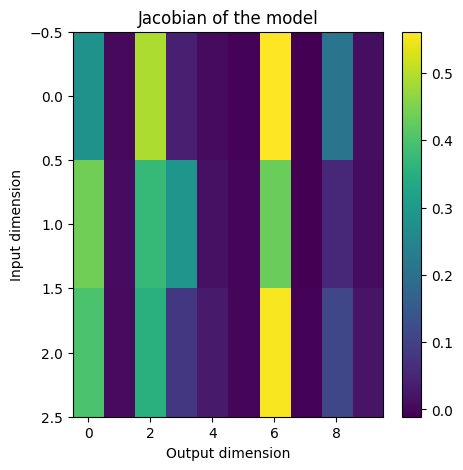

In [14]:
# Compute the tensorflow Jacobian
x_sample = x_train[0:1, :]
tfmelt_jacobian = ann_model.compute_jacobian(x_sample)

print(f"Shape of tfmelt jacobian: {tfmelt_jacobian.shape}")

# Plot the Jacobian
plt.figure(figsize=(5, 5))
cb = plt.imshow(tfmelt_jacobian[0, :, 0, :], cmap="viridis", aspect="auto")
plt.colorbar(cb)
plt.title("Jacobian of the model")
plt.xlabel("Output dimension")
plt.ylabel("Input dimension")
plt.show()


In [15]:
from tfmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(ann_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(ann_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(ann_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)


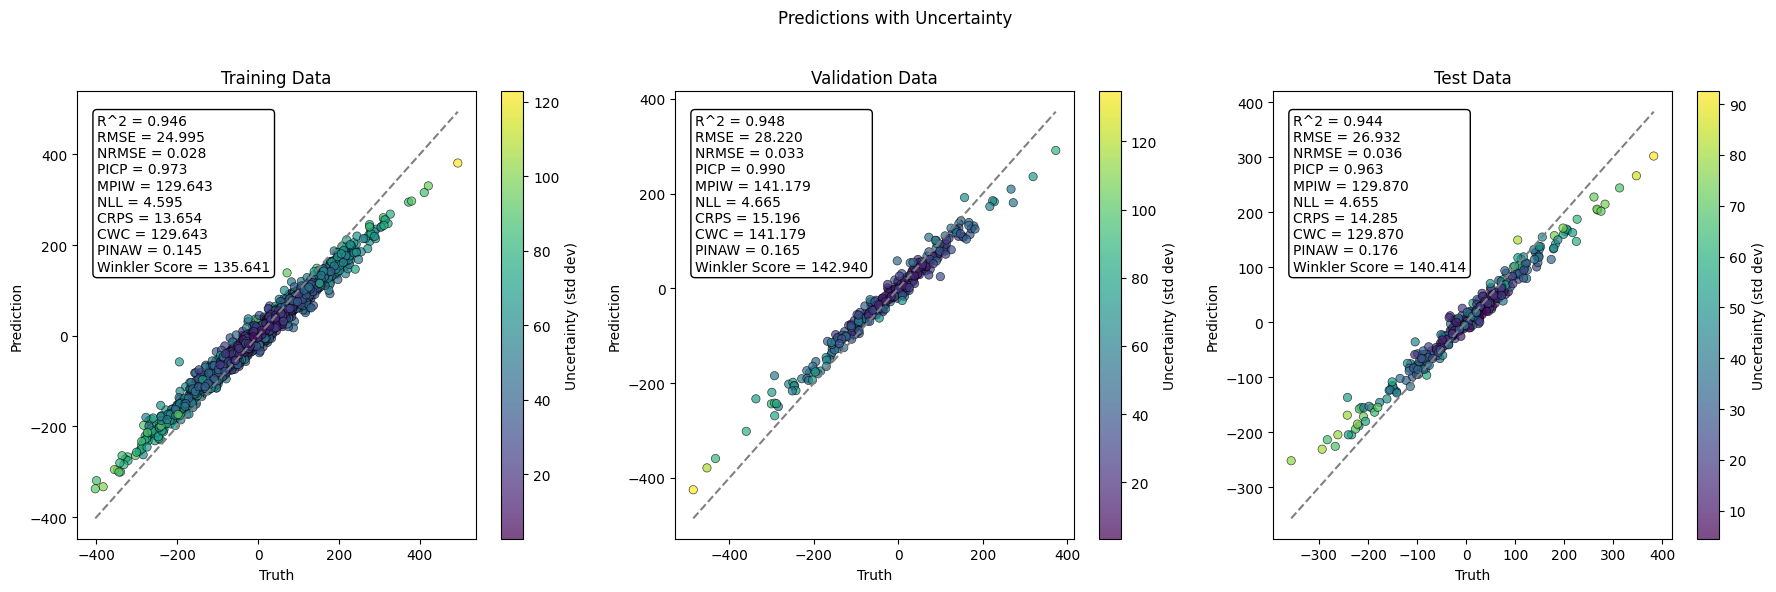

In [16]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"],
    metrics_to_display=None, # Display all metrics
)

## Residual Neural Network (ResNet)
Create and train a ResNet using TF-MELT.

In [17]:
from tfmelt.models import ResidualNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
resnet_model = ResidualNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    layers_per_block=layers_per_block,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    pre_activation=True,
    post_add_activation=False,
    output_activation=output_activation,
)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
resnet_model.build(input_shape=(None, n_features))
resnet_model.summary()


Model: "residual_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  27        
                                                                 
 residual_block (ResidualBl  multiple                  160       
 ock)                                                            
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              multiple                  

/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:316: UserWarning: Warning: Number of layers (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(
/Users/nwimer/NREL_Repos/tf-melt/tfmelt/blocks.py:219: UserWarning: Warning: Number of layers (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [18]:
# Train the model
history = resnet_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 2.2537 - val_loss: 1.8698
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 1.6851 - val_loss: 1.5211
Epoch 3/300
25/25 [==============================] - 0s 938us/step - loss: 1.3735 - val_loss: 1.3138
Epoch 4/300
25/25 [==============================] - 0s 978us/step - loss: 1.1692 - val_loss: 1.1713
Epoch 5/300
25/25 [==============================] - 0s 808us/step - loss: 1.0407 - val_loss: 1.0643
Epoch 6/300
25/25 [==============================] - 0s 846us/step - loss: 0.8964 - val_loss: 0.9800
Epoch 7/300
25/25 [==============================] - 0s 893us/step - loss: 0.8865 - val_loss: 0.8957
Epoch 8/300
25/25 [==============================] - 0s 970us/step - loss: 0.7881 - val_loss: 0.8284
Epoch 9/300
25/25 [==============================] - 0s 912us/step - loss: 0.7685 - val_loss: 0.7687
Epoch 10/300
25/25 [==============================] - 0s 893us/step - loss: 0.6718 - val_loss: 

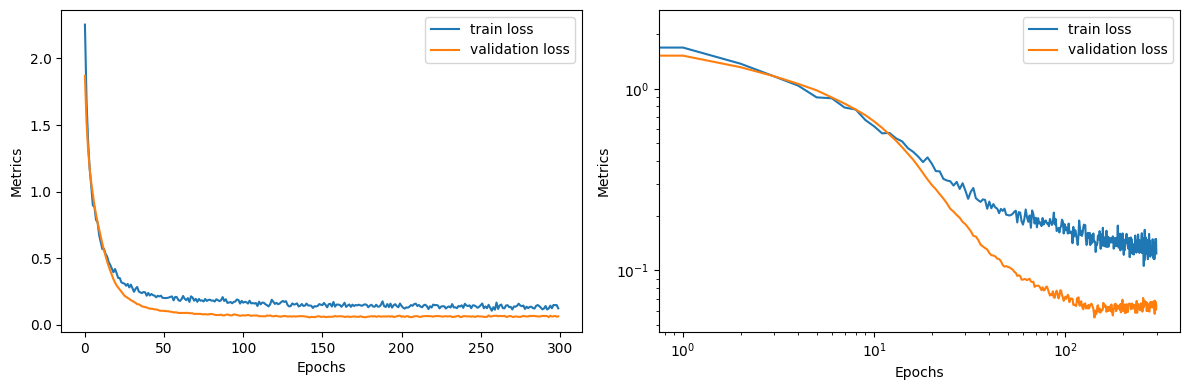

In [19]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [20]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(resnet_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(resnet_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(resnet_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

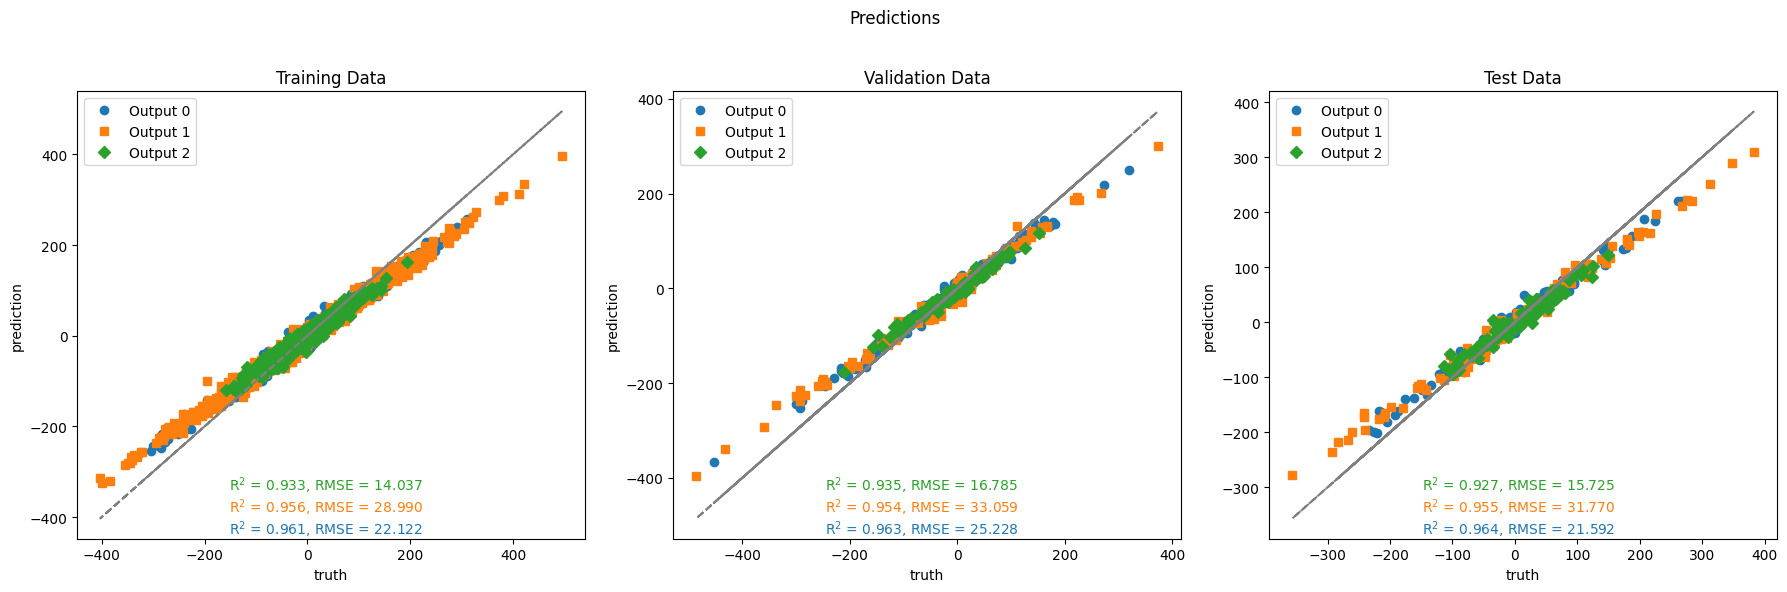

In [21]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

Let's do a test of the serialization and loading

INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets
/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:316: UserWarning: Warning: Number of layers (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(
/Users/nwimer/NREL_Repos/tf-melt/tfmelt/blocks.py:219: UserWarning: Warning: Number of layers (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


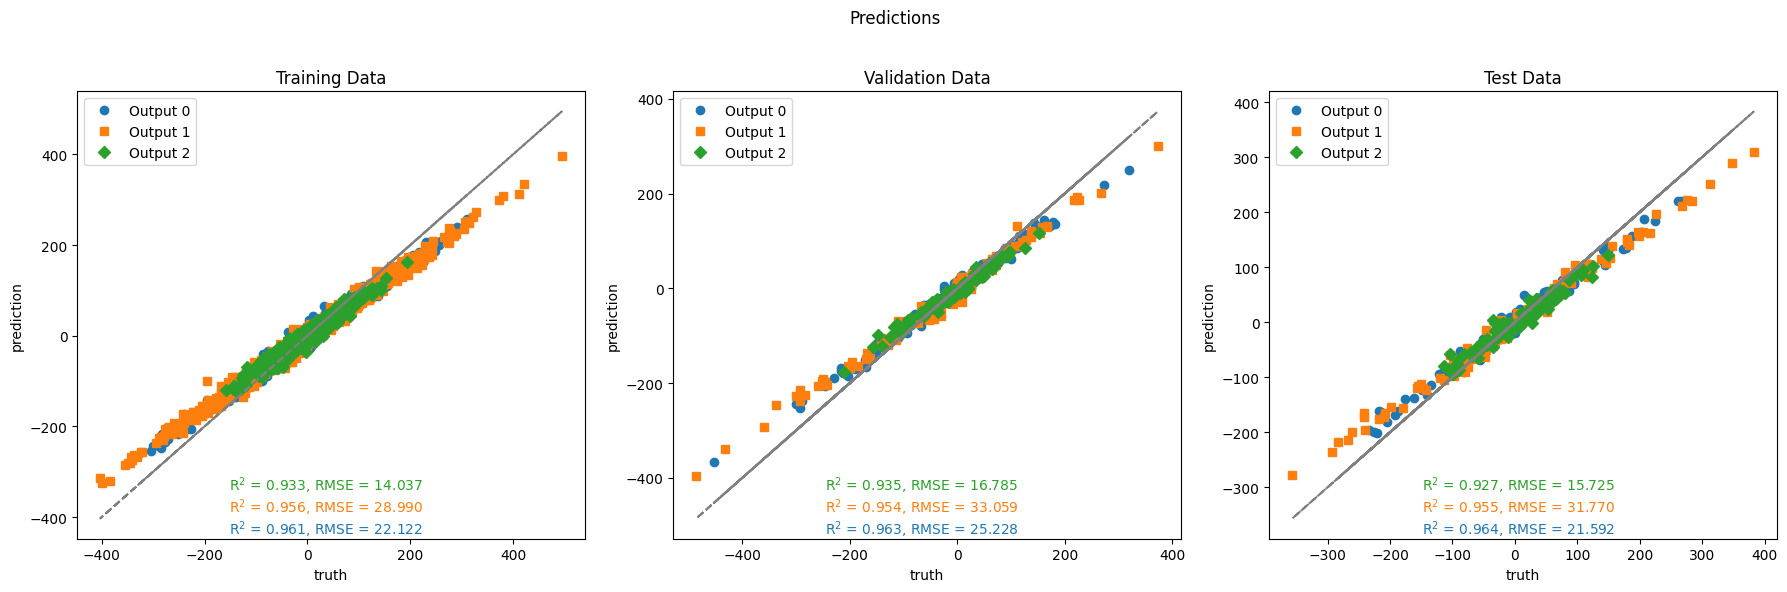

In [22]:
from tensorflow.keras.models import load_model

# Save the resnet model
resnet_model.save("resnet_model")

# Load the resnet model
resnet_model_loaded = load_model("resnet_model")

# Make predictions using the loaded model
pred_train_loaded = make_predictions(resnet_model_loaded, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val_loaded = make_predictions(resnet_model_loaded, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test_loaded = make_predictions(resnet_model_loaded, x_test, y_normalizer=y_normalizer, unnormalize=True)

# Plot the predictions
plot_predictions(pred_train_loaded, y_train_real, pred_val_loaded, y_val_real, pred_test_loaded, y_test_real)

In [23]:
from tfmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(resnet_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(resnet_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(resnet_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

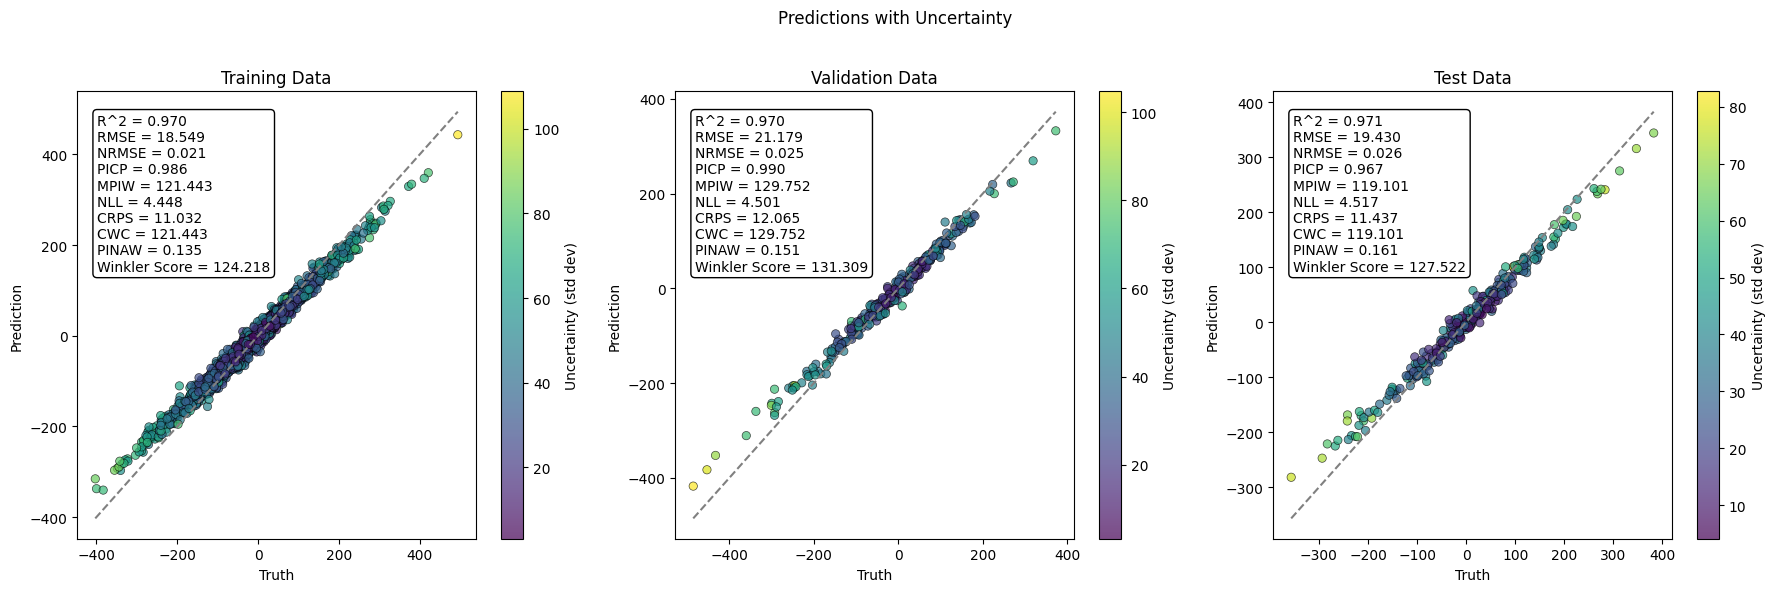

In [24]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

# Heteroscedastic ANN

Now enable the direct uncertainty prediction using a modified output layer through num_mixtures parameter

In [25]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
hnn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_mixtures=1, # Single Gaussian mixture
)

# Compile the model
hnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
hnn_model.build(input_shape=(None, n_features))
hnn_model.summary()

Model: "artificial_neural_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mixture_density_output (Mi  multiple                  63        
 xtureDensityOutput)                                             
                                                                 
 dense_block (DenseBlock)    multiple                  160       
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 223 (892.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "mixture_density_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mix_coeffs (Dense)          multiple                  9         
                                                                 
 mean_output (Dense)         multip

/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:188: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [26]:
# Train the model
history = hnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 4ms/step - loss: 5.6523 - val_loss: 4.6035
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 4.1563 - val_loss: 3.9767
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 3.7241 - val_loss: 3.7277
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 3.5263 - val_loss: 3.5995
Epoch 5/300
25/25 [==============================] - 0s 803us/step - loss: 3.4088 - val_loss: 3.5201
Epoch 6/300
25/25 [==============================] - 0s 802us/step - loss: 3.3322 - val_loss: 3.4612
Epoch 7/300
25/25 [==============================] - 0s 795us/step - loss: 3.2739 - val_loss: 3.4176
Epoch 8/300
25/25 [==============================] - 0s 806us/step - loss: 3.2291 - val_loss: 3.3815
Epoch 9/300
25/25 [==============================] - 0s 786us/step - loss: 3.1920 - val_loss: 3.3518
Epoch 10/300
25/25 [==============================] - 0s 790us/step - loss: 3.1602 - val_loss: 3.32

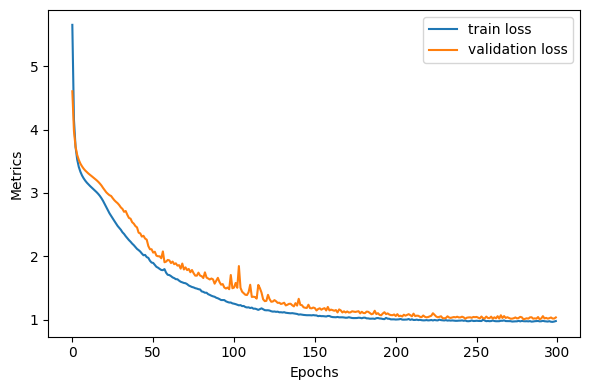

In [27]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [28]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(hnn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(hnn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(hnn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

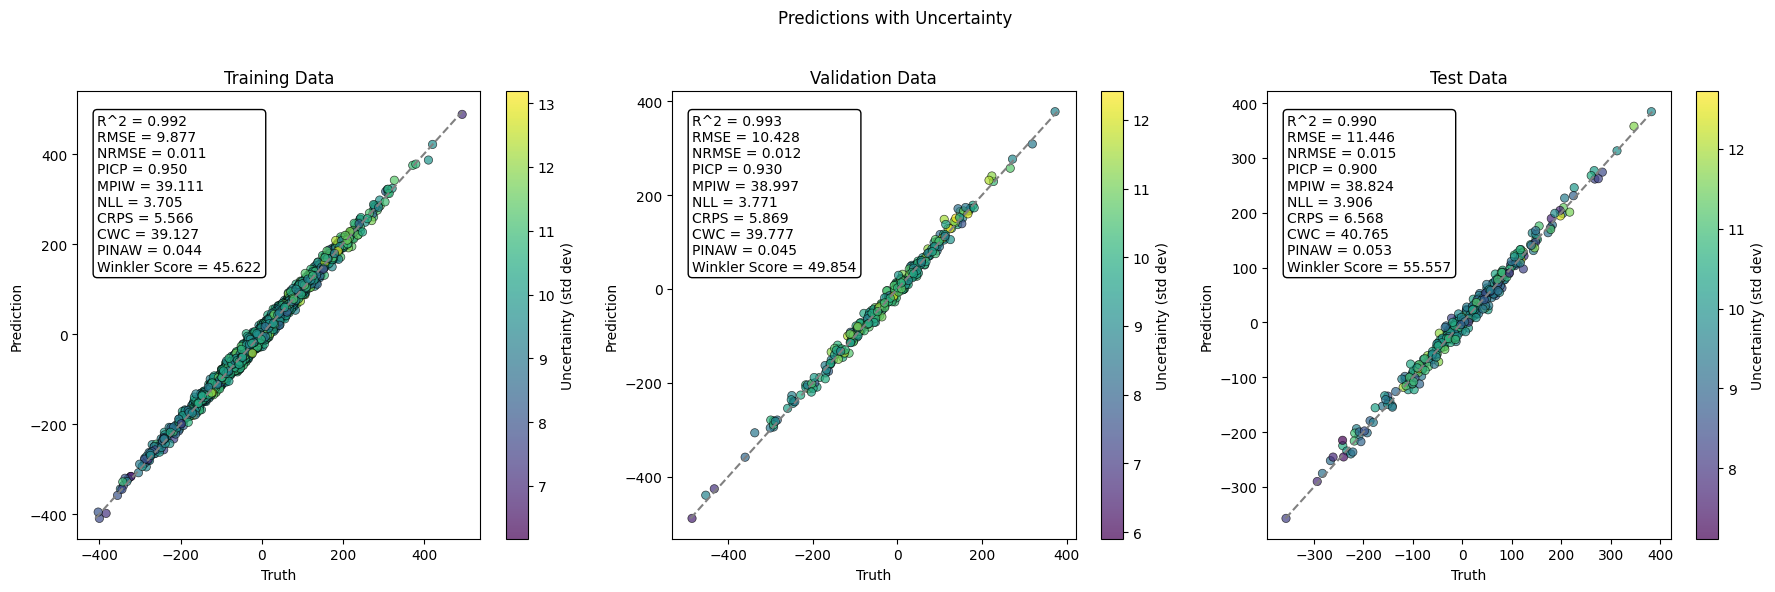

In [29]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)


Let's do a test of the serialization and loading

INFO:tensorflow:Assets written to: hnn_model/assets


INFO:tensorflow:Assets written to: hnn_model/assets
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:188: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(


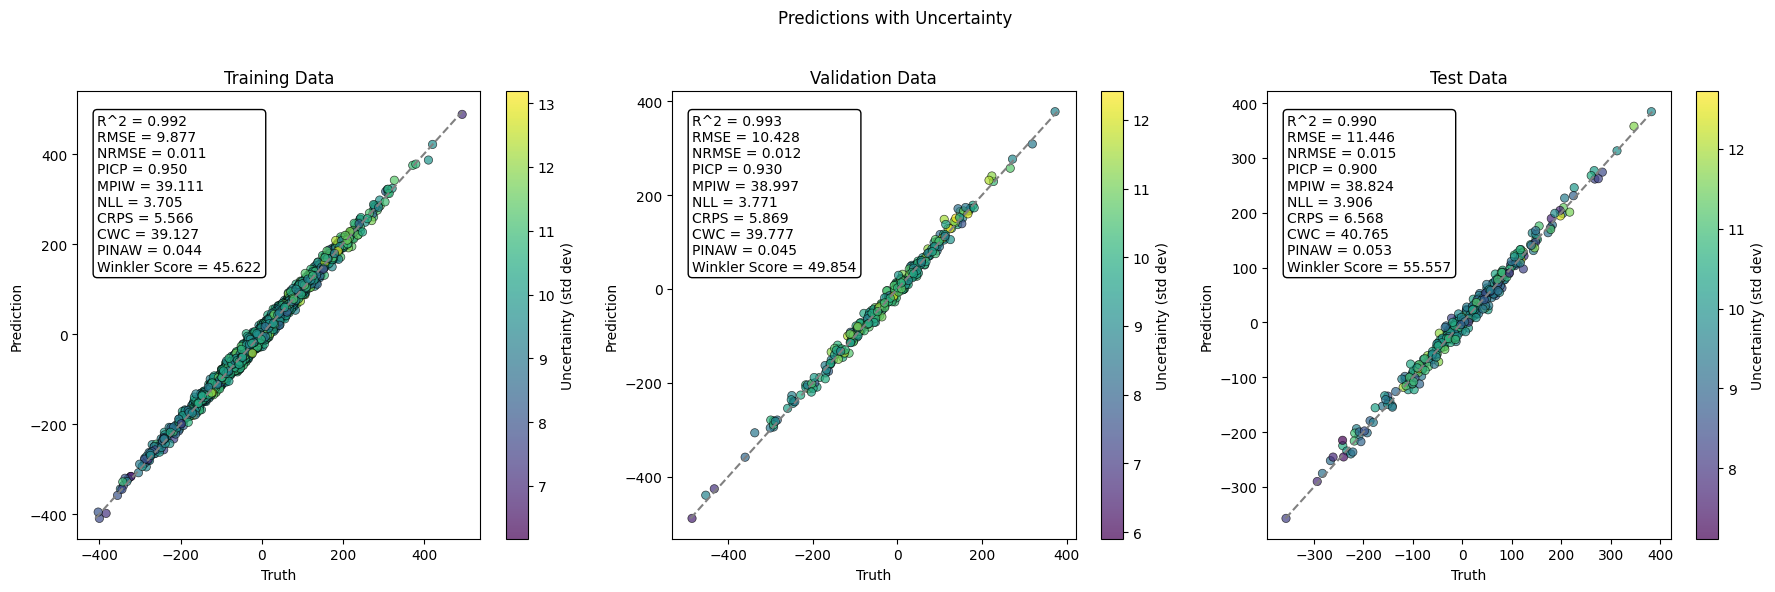

In [30]:
from tensorflow.keras.models import load_model
from tfmelt.losses import MixtureDensityLoss

# Save the hnn model
hnn_model.save("hnn_model")

# Load the hnn model
hnn_model_loaded = load_model("hnn_model", custom_objects={"MixtureDensityLoss": MixtureDensityLoss})

# Make predictions using the loaded model
pred_train_loaded, pred_train_std_loaded = make_predictions(hnn_model_loaded, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val_loaded, pred_val_std_loaded = make_predictions(hnn_model_loaded, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test_loaded, pred_test_std_loaded = make_predictions(hnn_model_loaded, x_test, y_normalizer=y_normalizer, unnormalize=True)

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train_loaded, pred_train_std_loaded, y_train_real,
    pred_val_loaded, pred_val_std_loaded, y_val_real,
    pred_test_loaded, pred_test_std_loaded, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

# Mixture Density Network
Now increase the number of mixture models for a true MDN

In [31]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
mdn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_mixtures=5, # 5 Gaussian mixtures
)

# Compile the model
mdn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
mdn_model.build(input_shape=(None, n_features))
mdn_model.summary()

Model: "artificial_neural_network_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mixture_density_output (Mi  multiple                  315       
 xtureDensityOutput)                                             
                                                                 
 dense_block (DenseBlock)    multiple                  160       
                                                                 
Total params: 475 (1.86 KB)
Trainable params: 475 (1.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "mixture_density_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mix_coeffs (Dense)          multiple                  45        
                                                                 
 mean_output (Dense)         multiple      

/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:188: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [32]:
# Train the model
history = mdn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 4ms/step - loss: 3.2591 - val_loss: 3.4492
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 3.2377 - val_loss: 3.4329
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 3.2207 - val_loss: 3.4151
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 3.2013 - val_loss: 3.3904
Epoch 5/300
25/25 [==============================] - 0s 898us/step - loss: 3.1750 - val_loss: 3.3557
Epoch 6/300
25/25 [==============================] - 0s 916us/step - loss: 3.1384 - val_loss: 3.2950
Epoch 7/300
25/25 [==============================] - 0s 874us/step - loss: 3.0861 - val_loss: 3.2237
Epoch 8/300
25/25 [==============================] - 0s 1ms/step - loss: 3.0184 - val_loss: 3.1253
Epoch 9/300
25/25 [==============================] - 0s 879us/step - loss: 2.9350 - val_loss: 3.0031
Epoch 10/300
25/25 [==============================] - 0s 868us/step - loss: 2.8402 - val_loss: 2.8983

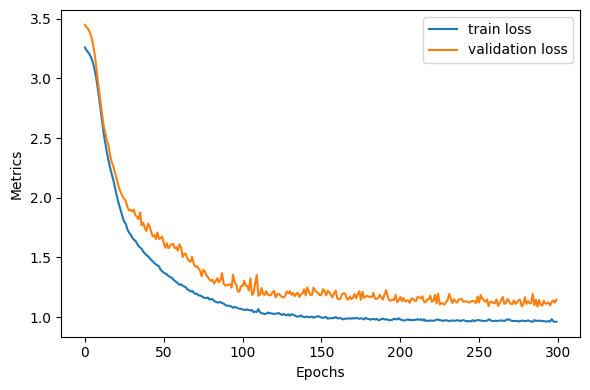

In [33]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [34]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(mdn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(mdn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(mdn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

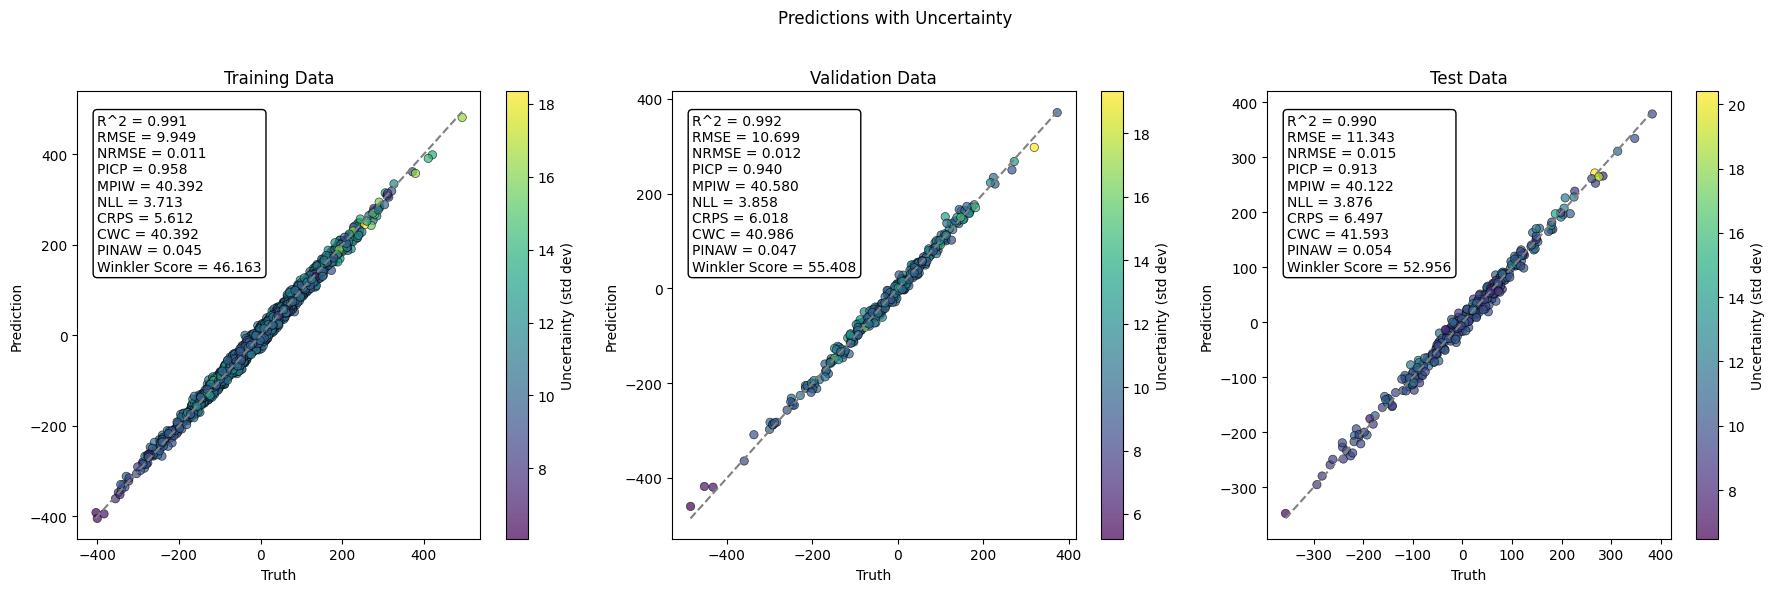

In [35]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

Let's test serialization and loading

INFO:tensorflow:Assets written to: mdn_model/assets


INFO:tensorflow:Assets written to: mdn_model/assets
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:188: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(


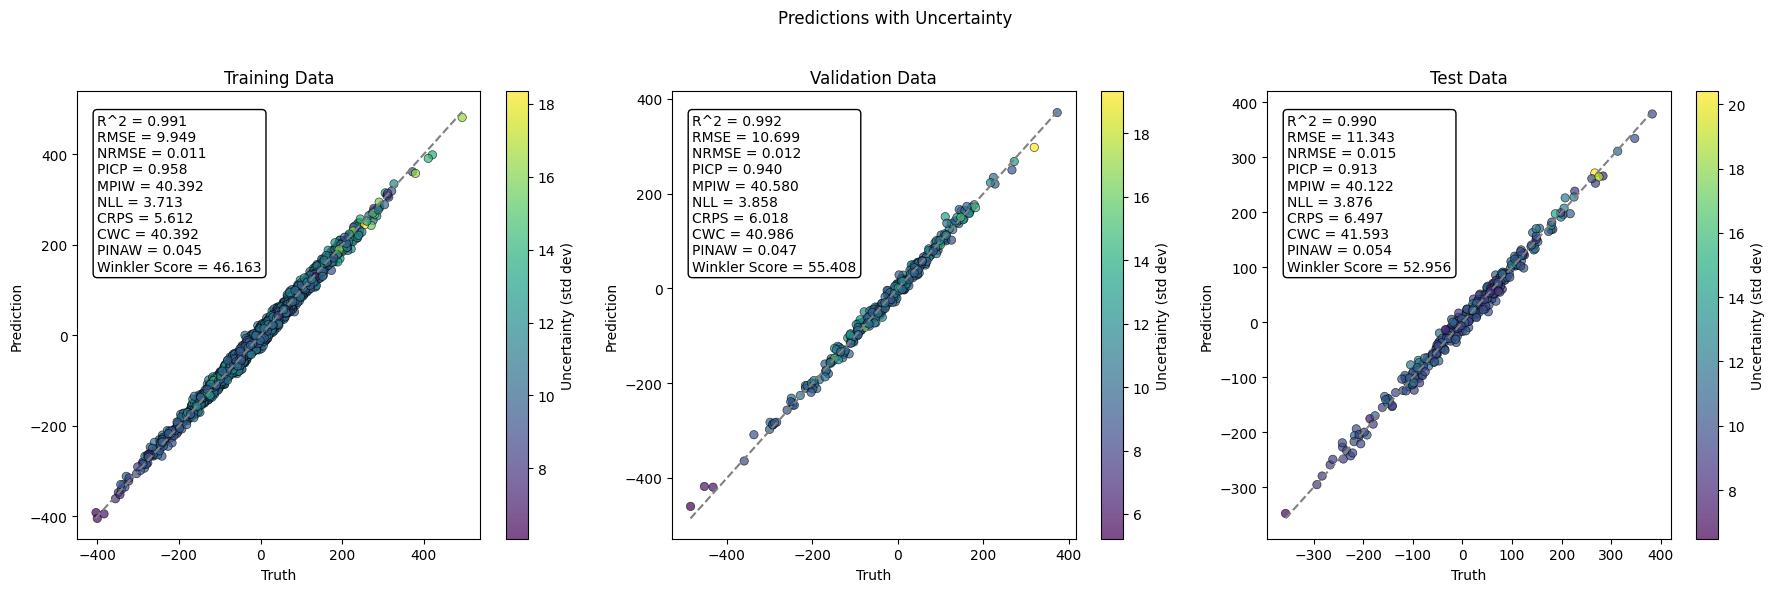

In [36]:
from tensorflow.keras.models import load_model
from tfmelt.losses import MixtureDensityLoss

# Save the mdn model
mdn_model.save("mdn_model")

# Load the mdn model
mdn_model_loaded = load_model("mdn_model", custom_objects={"MixtureDensityLoss": MixtureDensityLoss})

# Make predictions using the loaded model
pred_train_loaded, pred_train_std_loaded = make_predictions(mdn_model_loaded, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val_loaded, pred_val_std_loaded = make_predictions(mdn_model_loaded, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test_loaded, pred_test_std_loaded = make_predictions(mdn_model_loaded, x_test, y_normalizer=y_normalizer, unnormalize=True)

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train_loaded, pred_train_std_loaded, y_train_real,
    pred_val_loaded, pred_val_std_loaded, y_val_real,
    pred_test_loaded, pred_test_std_loaded, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

## Bayesian Neural Network (BNN)
Create and train a BNN using TF-MELT. We can specify the number of bayesian layers desired to increase complexity.

#### Epistemic Uncertainty Predictions
We will turn off the aleatoric output layer and instead train an epistemic BNN model (of varying number of layers). Predictions will be made using Monte Carlo methods.

In [37]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# import tensorflow as tf
# import tensorflow_probability as tfp
# import numpy as np
# import random

# # Set random seeds for reproducibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
do_aleatoric = False

# We can create a BNN with arbitrary Bayesian layers
# node_list = [8, 8, 8]
# bayesian_mask = [True, False, True]

node_list = [256]
bayesian_mask = [True]

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    do_aleatoric=do_aleatoric,
    node_list=node_list,
    bayesian_mask=bayesian_mask,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()


Model: "bayesian_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (DefaultOutput)      multiple                  1539      
                                                                 
 bayesian_block_0 (Bayesian  multiple                  5376      
 Block)                                                          
                                                                 
Total params: 6915 (27.01 KB)
Trainable params: 6915 (27.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bayesian_output (DenseFlip  multiple                  1539      
 out)                                                            
                                                           

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [38]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 1s 6ms/step - loss: 11.2753 - val_loss: 11.0893
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 10.7126 - val_loss: 10.5716
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 10.4610 - val_loss: 10.3839
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 10.3392 - val_loss: 10.2986
Epoch 5/300
25/25 [==============================] - 0s 1ms/step - loss: 10.2470 - val_loss: 10.2093
Epoch 6/300
25/25 [==============================] - 0s 1ms/step - loss: 10.1571 - val_loss: 10.1201
Epoch 7/300
25/25 [==============================] - 0s 1ms/step - loss: 10.0641 - val_loss: 10.0186
Epoch 8/300
25/25 [==============================] - 0s 1ms/step - loss: 9.9765 - val_loss: 9.9343
Epoch 9/300
25/25 [==============================] - 0s 1ms/step - loss: 9.8801 - val_loss: 9.8387
Epoch 10/300
25/25 [==============================] - 0s 1ms/step - loss: 9.7826 - val_loss: 9.

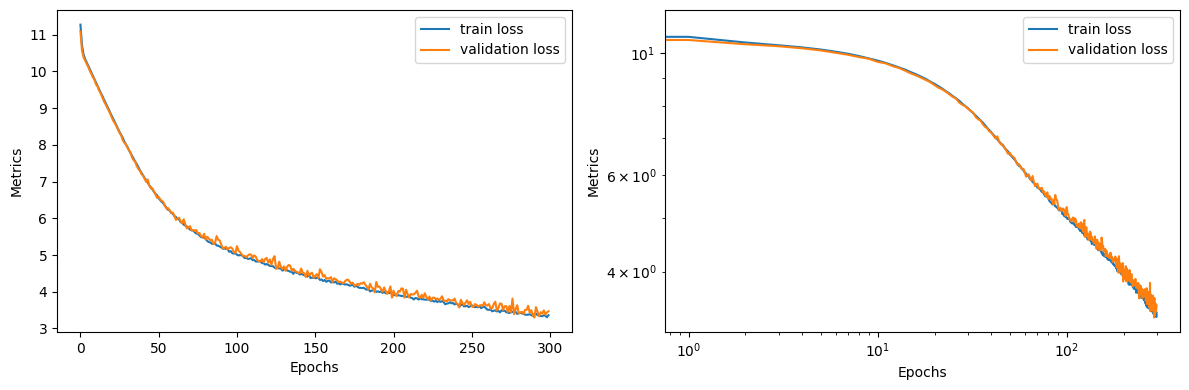

In [39]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [40]:
from tfmelt.utils.evaluation import ensemble_predictions

# Evaluate the model performance on train, validation, and test data
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(bnn_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(bnn_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(bnn_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

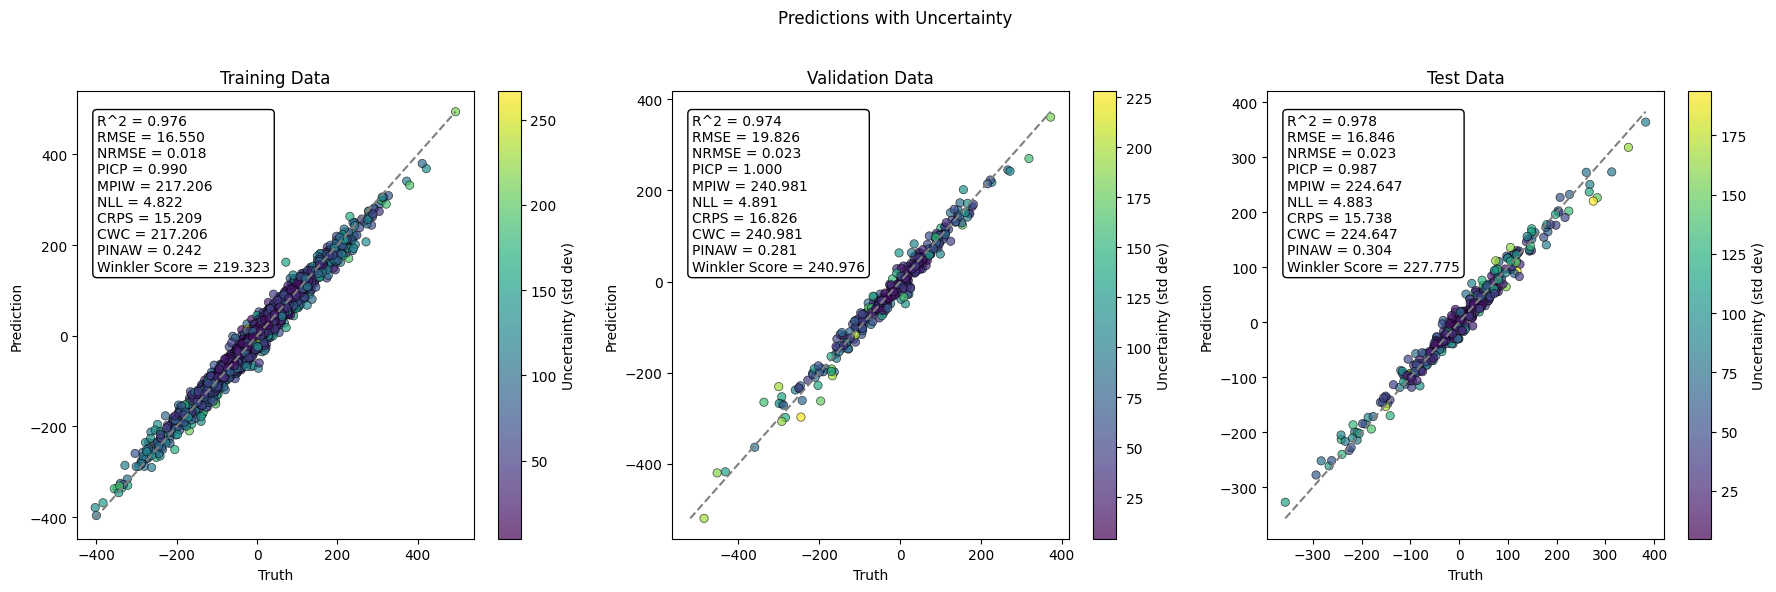

In [41]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions from the ensemble
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

Let's test serialization and loading

INFO:tensorflow:Assets written to: bnn_model/assets


INFO:tensorflow:Assets written to: bnn_model/assets
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


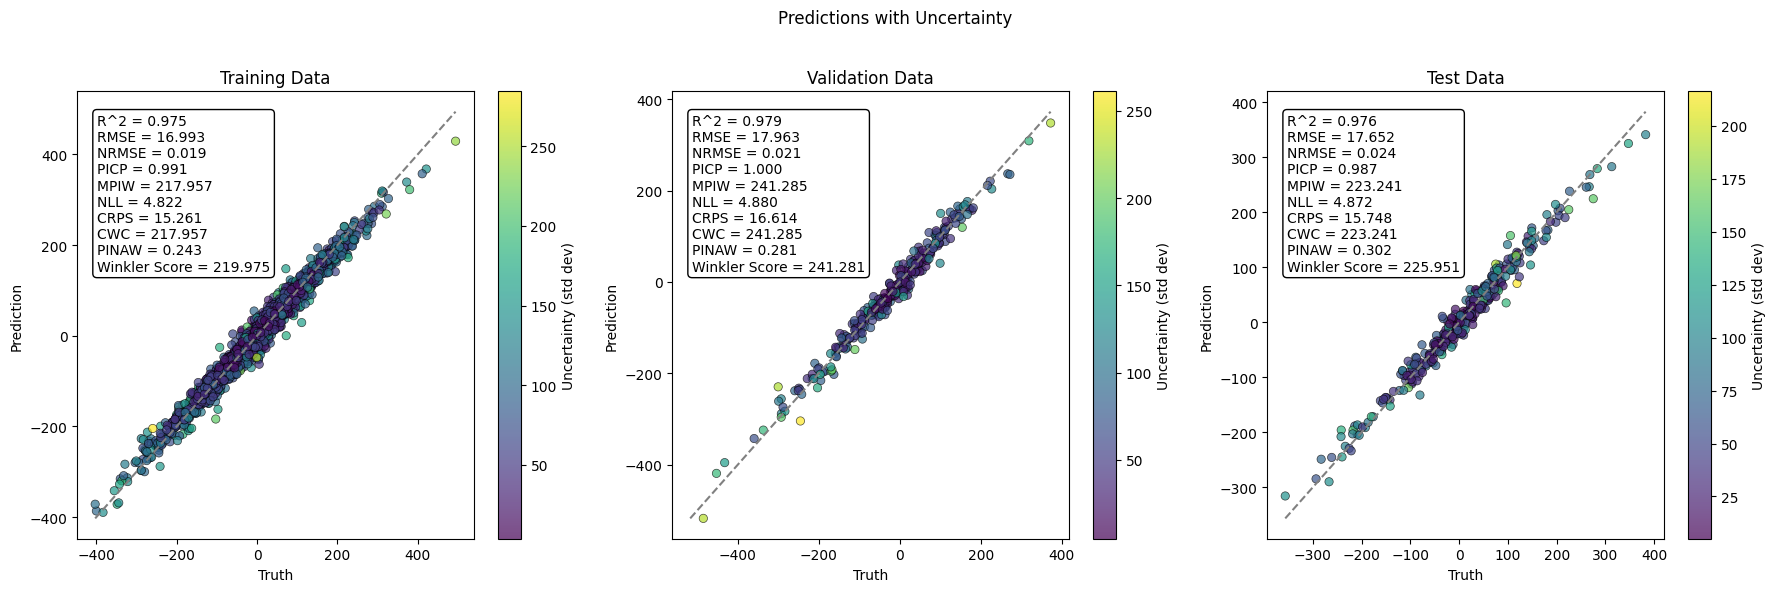

In [42]:
from tensorflow.keras.models import load_model

# Save the bnn model
bnn_model.save("bnn_model")

# Load the bnn model
bnn_model_loaded = load_model("bnn_model")

# Make predictions using the loaded model
pred_train_mean, pred_train_std = ensemble_predictions(bnn_model_loaded, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(bnn_model_loaded, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(bnn_model_loaded, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

# Plot the predictions from the ensemble
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

#### Aleatoric Uncertainty Predictions
Now examine aleatoric uncertainty predictions as well as combined predictions if there are more than 1 Bayesian layer. The number of Bayesian layers can be set in through the `bayesian_mask` input, which is a list of booleans indicating if a given layer should be made Bayesian.

TODO: Extract these visualization scripts into the tfmelt.utils.visualization submodule

In [43]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
do_aleatoric = True
batch_norm = True
use_batch_renorm = True
n_epochs = 200
l1_reg = 0
l2_reg = 0

node_list = [8, 8, 8]
bayesian_mask = [True, False, True]

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    do_aleatoric=do_aleatoric,
    use_batch_renorm=use_batch_renorm,
    node_list=node_list,
    bayesian_mask=bayesian_mask,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()

Model: "bayesian_neural_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (BayesianAleatoricO  multiple                  102       
 utput)                                                          
                                                                 
 dense_block_0 (DenseBlock)  multiple                  128       
                                                                 
 bayesian_block_0 (Bayesian  multiple                  200       
 Block)                                                          
                                                                 
 bayesian_block_1 (Bayesian  multiple                  168       
 Block)                                                          
                                                                 
Total params: 598 (2.34 KB)
Trainable params: 526 (2.05 KB)
Non-trainable params: 72 (288.00 Byte)
________

/Users/nwimer/NREL_Repos/tf-melt/tfmelt/models.py:579: UserWarning: Loss function is overridden when using aleatoric uncertainty. Using the negative log likelihood loss function.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [44]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/200
25/25 [==============================] - 1s 11ms/step - loss: 2.1590 - val_loss: 2.5916
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 2.1098 - val_loss: 2.5769
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 2.0566 - val_loss: 2.5447
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 1.9496 - val_loss: 2.4785
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 1.7968 - val_loss: 2.3348
Epoch 6/200
25/25 [==============================] - 0s 1ms/step - loss: 1.6645 - val_loss: 2.1187
Epoch 7/200
25/25 [==============================] - 0s 1ms/step - loss: 1.5745 - val_loss: 1.9331
Epoch 8/200
25/25 [==============================] - 0s 1ms/step - loss: 1.4868 - val_loss: 1.7172
Epoch 9/200
25/25 [==============================] - 0s 1ms/step - loss: 1.4436 - val_loss: 1.5453
Epoch 10/200
25/25 [==============================] - 0s 1ms/step - loss: 1.3935 - val_loss: 1.4617
Epoch 11

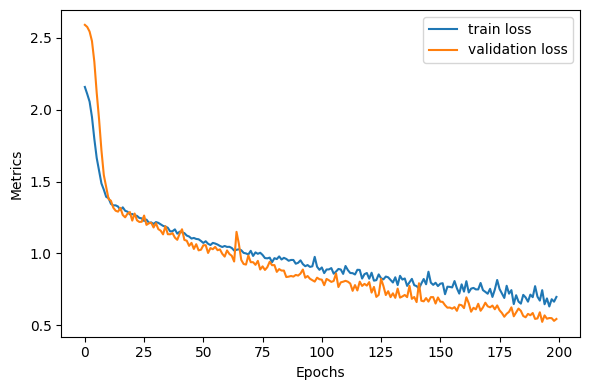

In [45]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [46]:
# Evaluate the model performance with Monte Carlo ensemble predictions for Aleatoric and Epistemic Uncertainty
import numpy as np
import tensorflow_probability as tfp

num_preds = 100
pred_norm_train = np.stack([bnn_model(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([bnn_model(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([bnn_model(x_test, training=False) for _ in range(num_preds)], axis=0)

# If we are using aleatoric uncertainty, we have to unscale the distribution parameters
if do_aleatoric:
    pred_train = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_train])
    pred_val = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_val])
    pred_test = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_test])

    pred_mean_train = np.stack([y.mean().numpy() for y in pred_train]).mean(axis=0)
    pred_eu_train = np.stack([y.mean().numpy() for y in pred_train]).std(axis=0)
    pred_au_train = np.stack([y.stddev().numpy() for y in pred_train]).mean(axis=0)

    pred_mean_val = np.stack([y.mean().numpy() for y in pred_val]).mean(axis=0)
    pred_eu_val = np.stack([y.mean().numpy() for y in pred_val]).std(axis=0)
    pred_au_val = np.stack([y.stddev().numpy() for y in pred_val]).mean(axis=0)

    pred_mean_test = np.stack([y.mean().numpy() for y in pred_test]).mean(axis=0)
    pred_eu_test = np.stack([y.mean().numpy() for y in pred_test]).std(axis=0)
    pred_au_test = np.stack([y.stddev().numpy() for y in pred_test]).mean(axis=0)
    
# If we are not using aleatoric uncertainty, we can unscale the predictions directly
else:
    pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
    pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
    pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

    # Compute the mean and standard deviation of the predictions
    pred_mean_train = np.mean(pred_train, axis=0)
    pred_eu_train = np.std(pred_train, axis=0)
    pred_au_train = np.zeros(pred_mean_train.shape)

    pred_mean_val = np.mean(pred_val, axis=0)
    pred_eu_val = np.std(pred_val, axis=0)
    pred_au_val = np.zeros(pred_mean_val.shape)

    pred_mean_test = np.mean(pred_test, axis=0)
    pred_eu_test = np.std(pred_test, axis=0)
    pred_au_test = np.zeros(pred_mean_test.shape)



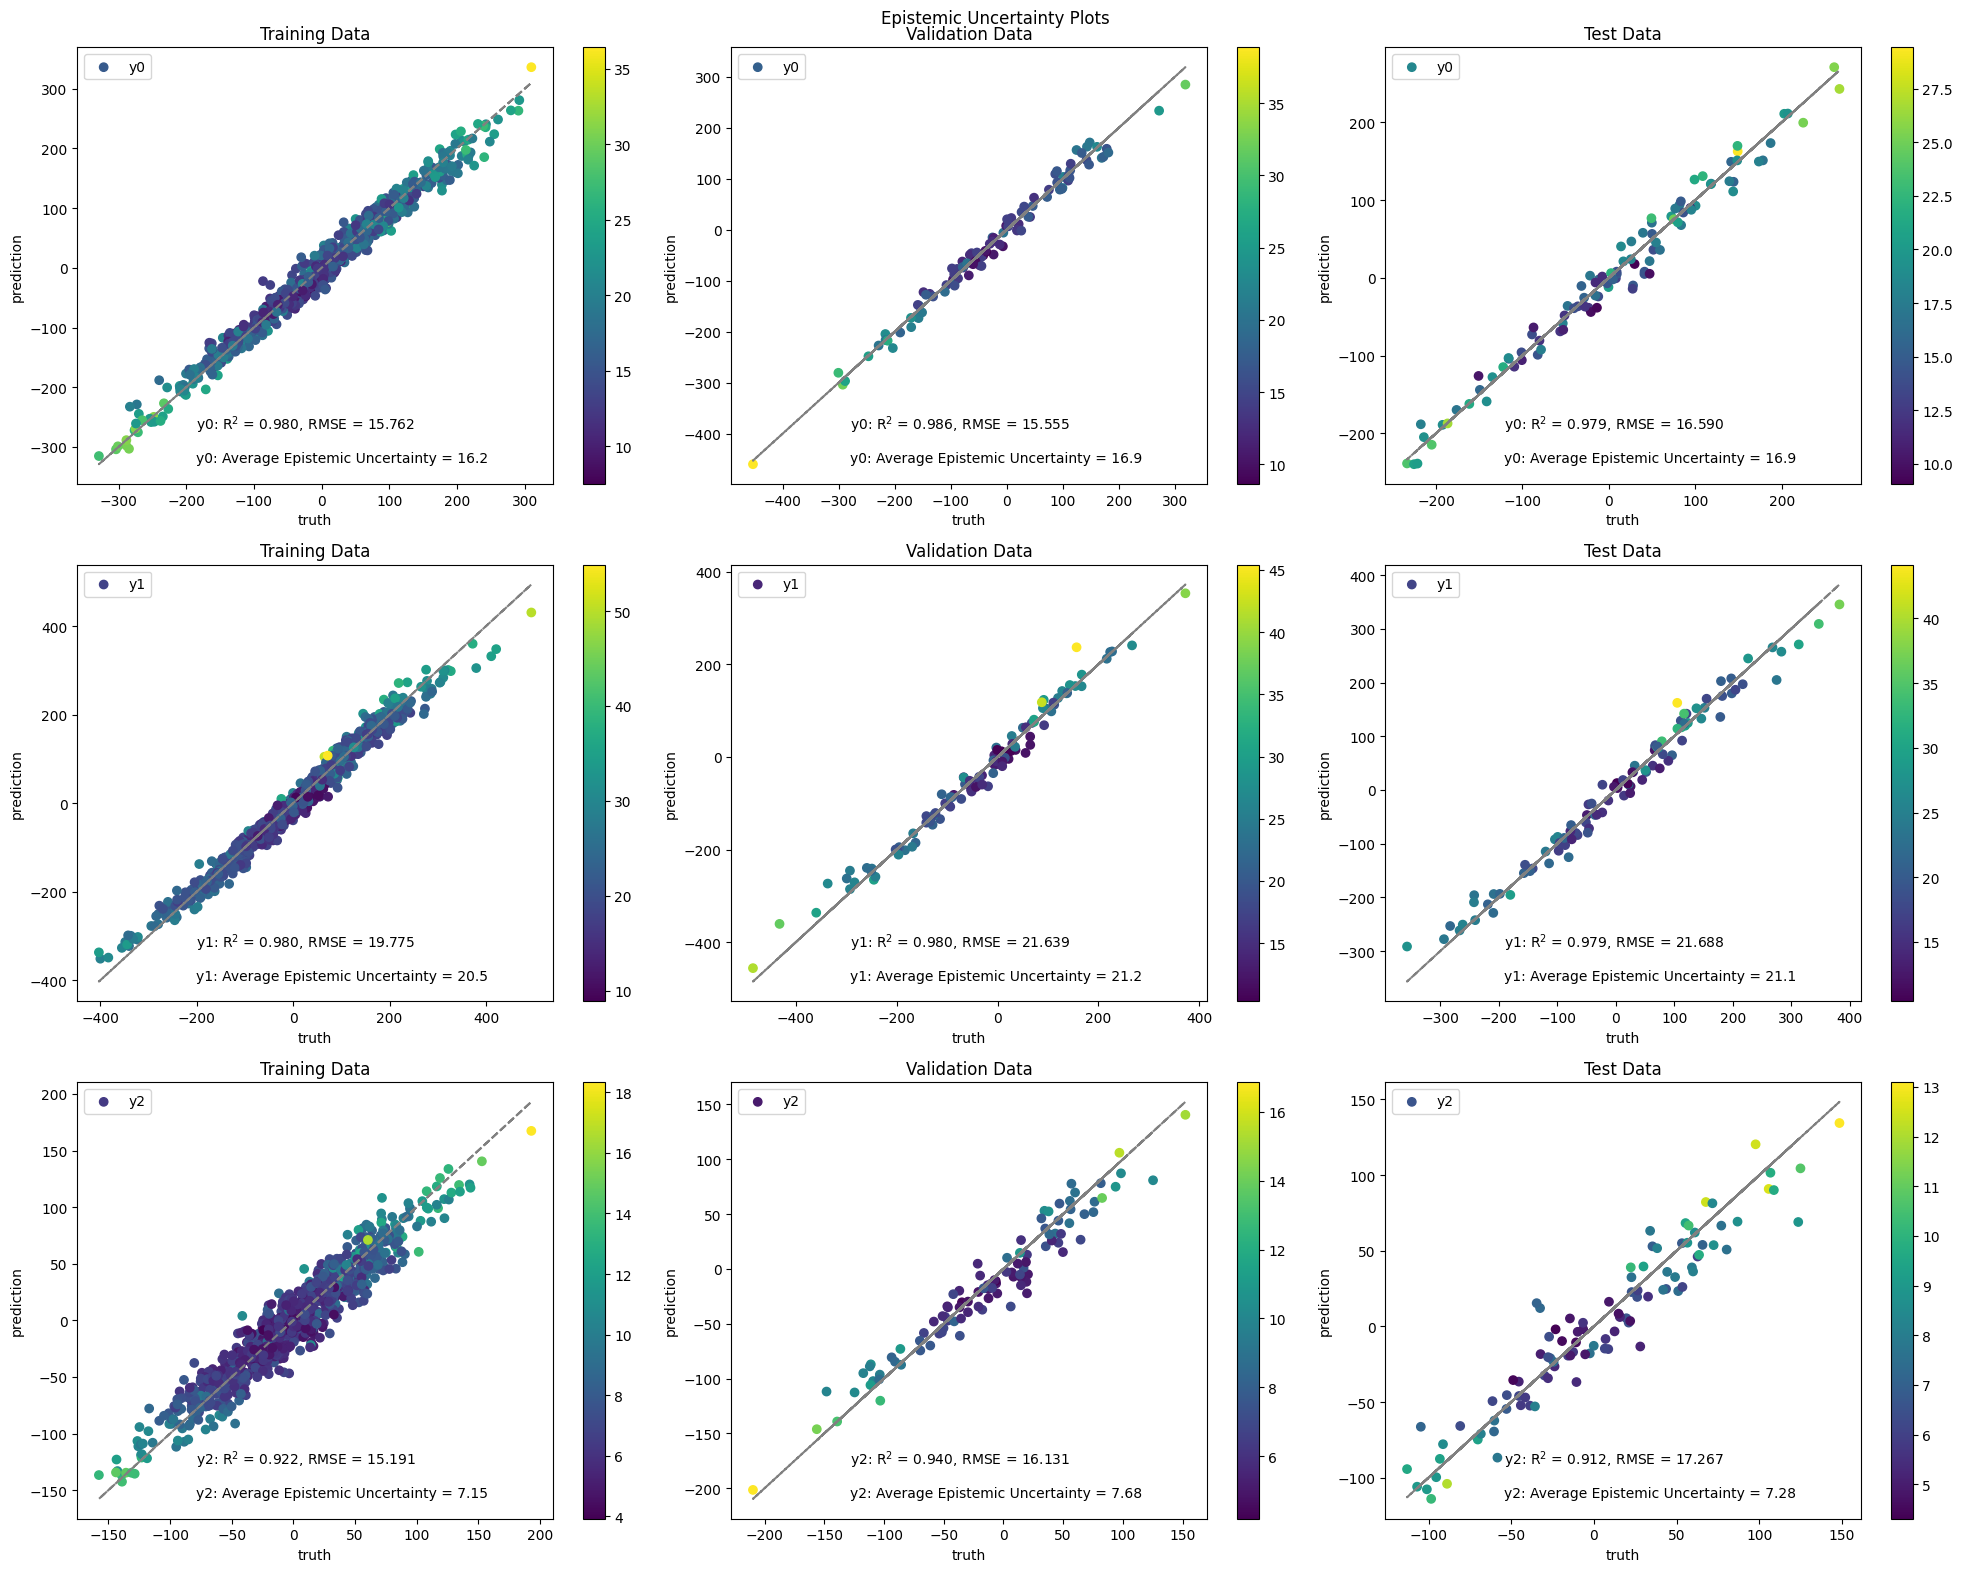

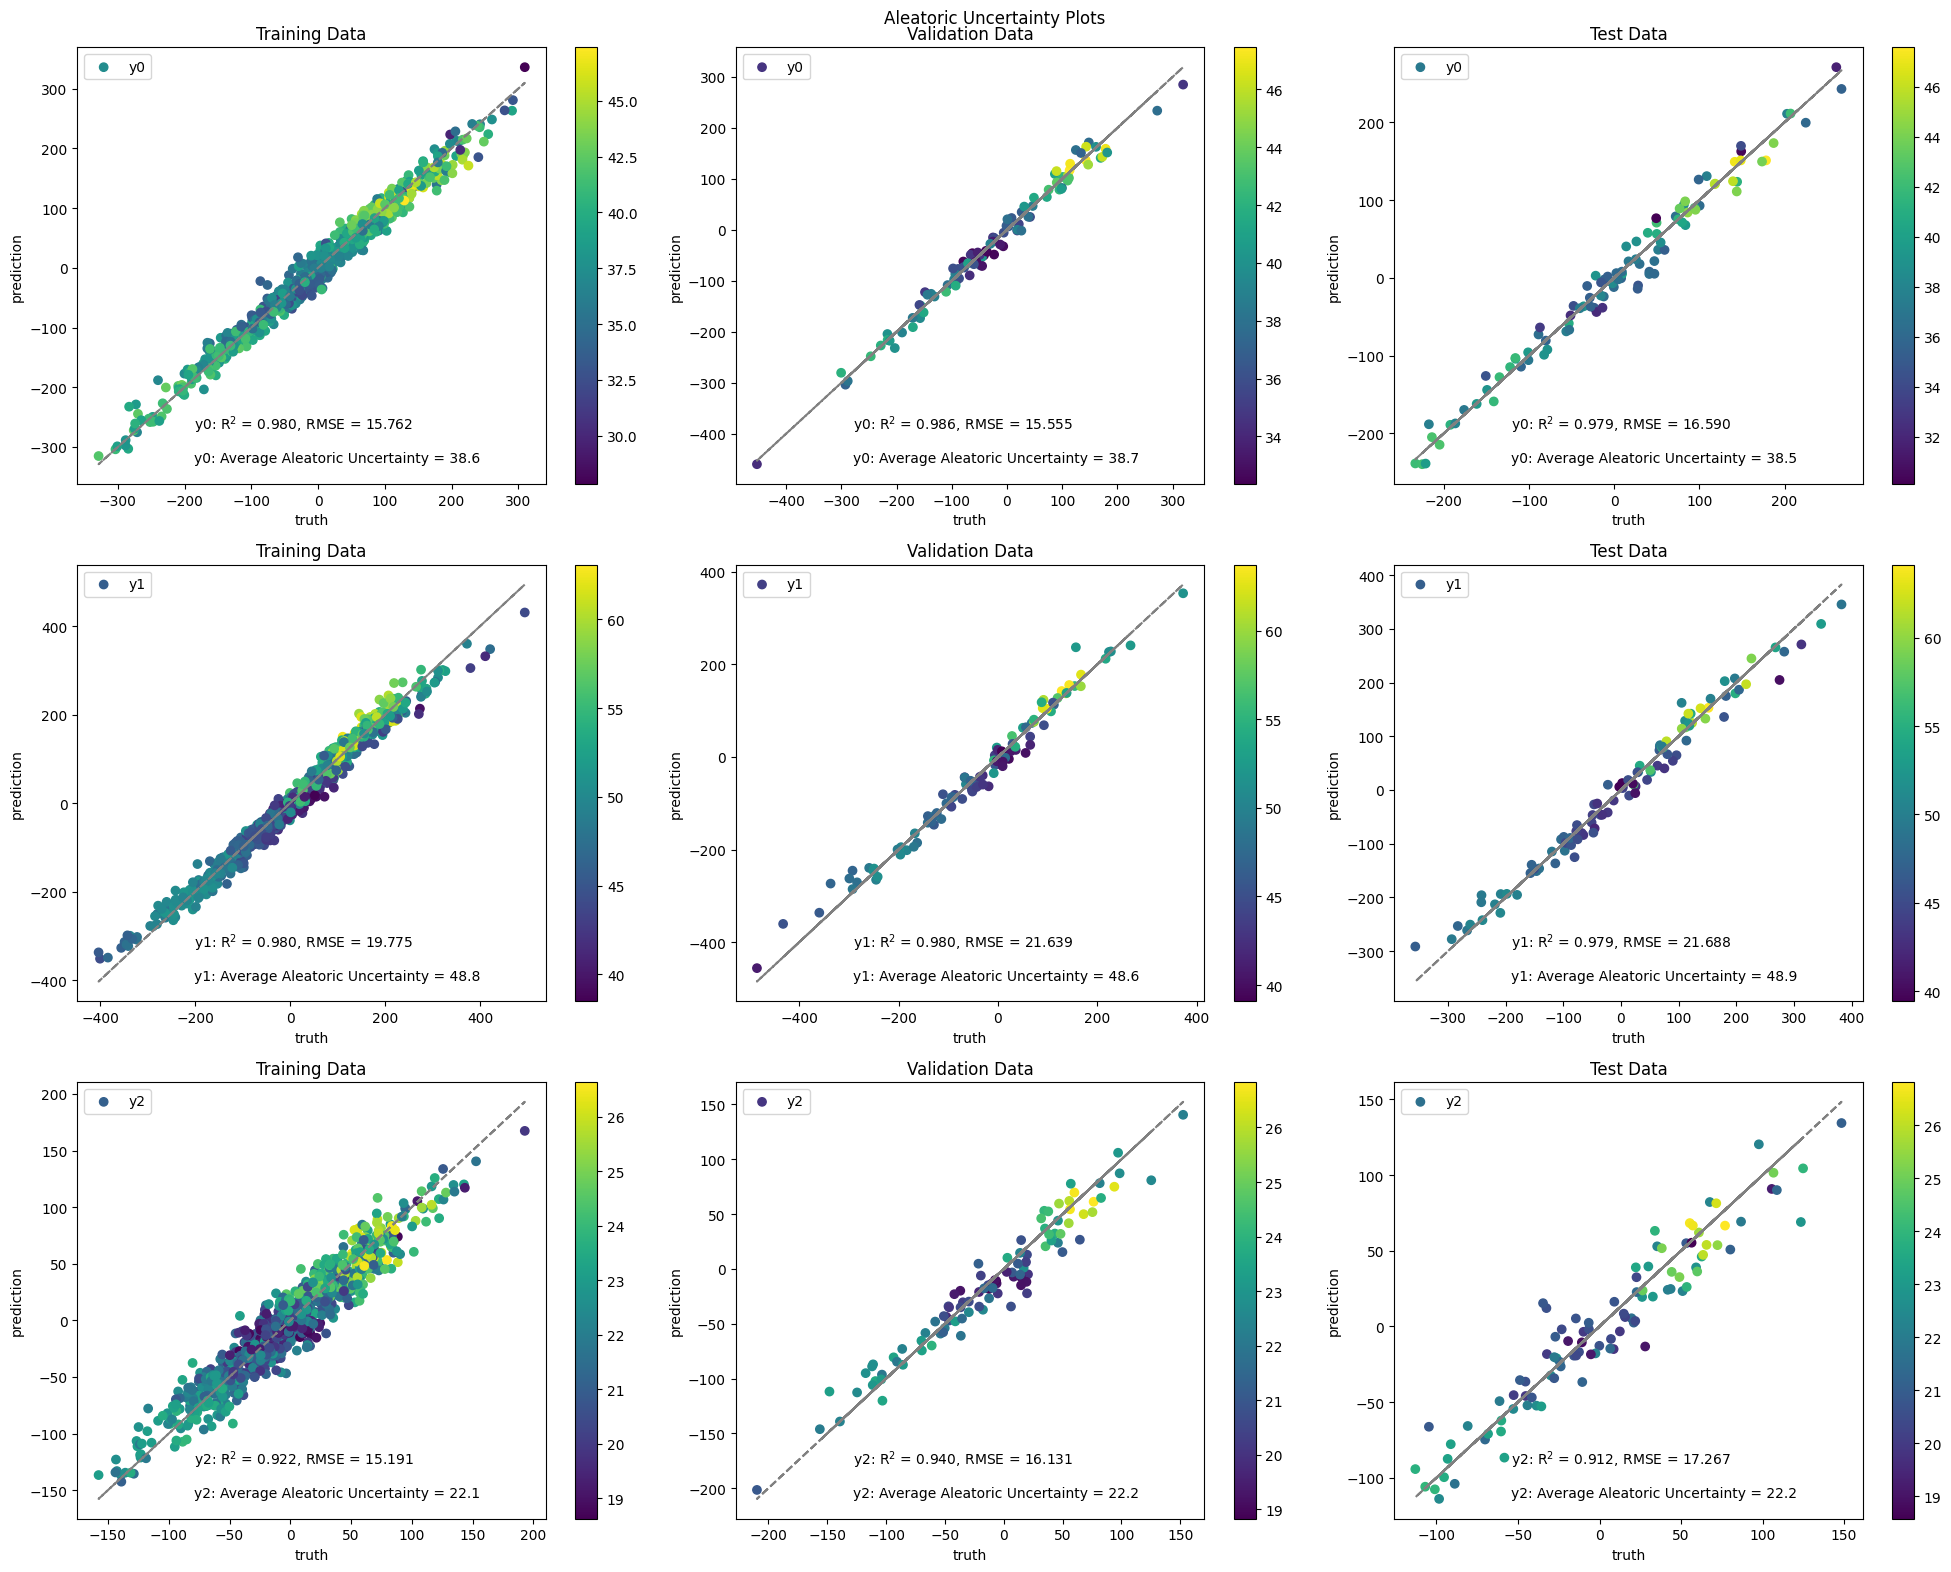

In [47]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)


# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Epistemic Uncertainty Plots')
fig.tight_layout()
plt.show()

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Aleatoric Uncertainty Plots')
fig.tight_layout()
plt.show()